In [16]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import glob
import tqdm
import random
import pickle
from collections import defaultdict
import requests
import PIL


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.8.2+cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Mock

# Set up the Model

In [17]:
model_name = "squeezenet"
batch_size = 8
num_epochs = 5
feature_extract = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(use_pretrained=True):
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    input_size = 224
    return model_ft, input_size

model_ft, input_size = initialize_model()

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [31]:
class SqueezenetBottom(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetBottom, self).__init__()
        self.features = nn.Sequential(*list(list(original_model.children())[0].children())[:15], nn.Flatten())

    def forward(self, x):
        x = self.features(x)
        return x

class SqueezenetTop(nn.Module):
    def __init__(self, original_model):
        super(SqueezenetTop, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[1])

    def forward(self, x):
        x = x.view((-1, 512, 13, 13))
        x = self.features(x)
        x = x.view((-1, 1000))
        x = nn.Softmax(dim=-1)(x)
        return x

def get_model_parts(model):    
    model_bottom = SqueezenetBottom(model)
    model_top = SqueezenetTop(model)
    return model_bottom, model_top

model_bottom, model_top = get_model_parts(model_ft)
model_bottom.eval()
model_top.eval();

# Evaluation Methods

In [25]:
concept_dict = pickle.load(open('sq_concepts_170.pkl', 'rb'))

In [32]:
response = requests.get("https://git.io/JJkYN")
class_labels = response.text.split("\n")

In [37]:
class_labels

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

In [200]:
def get_concept_scores(tensor, label):
    correct_idx = class_labels.index(label)
    concept_scores = {}
    embedding = model_bottom(tensor)
    original_preds = model_top(embedding).detach().numpy().squeeze()
    
    multiplier = 100000
    
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        plus = torch.from_numpy(embedding.detach().numpy() + multiplier*coef).float()
        plus_preds = model_top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key] = float(plus_diff)
        
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return original_preds[correct_idx], concept_scores, concept_scores_list    

In [56]:
from PIL import Image
import numpy as np
import colorsys

def rgb_to_hsv(rgb):
    # Translated from source of colorsys.rgb_to_hsv
    # r,g,b should be a numpy arrays with values between 0 and 255
    # rgb_to_hsv returns an array of floats between 0.0 and 1.0.
    rgb = rgb.astype('float')
    hsv = np.zeros_like(rgb)
    # in case an RGBA array was passed, just copy the A channel
    hsv[..., 3:] = rgb[..., 3:]
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    maxc = np.max(rgb[..., :3], axis=-1)
    minc = np.min(rgb[..., :3], axis=-1)
    hsv[..., 2] = maxc
    mask = maxc != minc
    hsv[mask, 1] = (maxc - minc)[mask] / maxc[mask]
    rc = np.zeros_like(r)
    gc = np.zeros_like(g)
    bc = np.zeros_like(b)
    rc[mask] = (maxc - r)[mask] / (maxc - minc)[mask]
    gc[mask] = (maxc - g)[mask] / (maxc - minc)[mask]
    bc[mask] = (maxc - b)[mask] / (maxc - minc)[mask]
    hsv[..., 0] = np.select(
        [r == maxc, g == maxc], [bc - gc, 2.0 + rc - bc], default=4.0 + gc - rc)
    hsv[..., 0] = (hsv[..., 0] / 6.0) % 1.0
    return hsv

def hsv_to_rgb(hsv):
    # Translated from source of colorsys.hsv_to_rgb
    # h,s should be a numpy arrays with values between 0.0 and 1.0
    # v should be a numpy array with values between 0.0 and 255.0
    # hsv_to_rgb returns an array of uints between 0 and 255.
    rgb = np.empty_like(hsv)
    rgb[..., 3:] = hsv[..., 3:]
    h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    i = (h * 6.0).astype('uint8')
    f = (h * 6.0) - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))
    i = i % 6
    conditions = [s == 0.0, i == 1, i == 2, i == 3, i == 4, i == 5]
    rgb[..., 0] = np.select(conditions, [v, q, p, p, t, v], default=v)
    rgb[..., 1] = np.select(conditions, [v, v, v, q, p, p], default=t)
    rgb[..., 2] = np.select(conditions, [v, p, t, v, v, q], default=p)
    return rgb.astype('uint8')

def shift_hue(arr,hout):
    hsv=rgb_to_hsv(arr)
    hsv[...,0]=hout
    rgb=hsv_to_rgb(hsv)
    return rgb

def colorize(image, hue):
    arr = np.array(image)
    arr_ = shift_hue(arr, hue)
    image_ = Image.fromarray(arr_)
    return image_

In [127]:
img = PIL.Image.open("C:\\Users\\islam\\downloads\\apple3.jpg").convert("RGB")
img_ = PIL.Image.open("C:\\Users\\islam\\downloads\\apple3.jpg").convert("L").convert("RGB")

In [140]:
concept_scores_list

['stripes',
 'floor',
 'snow',
 'tree',
 'polka_dots',
 'brick',
 'fabric',
 'building',
 'frame',
 'airplane',
 'countertop',
 'bookcase',
 'figurine',
 'engine',
 'street_s',
 'bannister',
 'eye',
 'board',
 'blotchy',
 'earth',
 'house',
 'balcony',
 'can',
 'redness',
 'book',
 'chain_wheel',
 'sofa',
 'pipe',
 'car',
 'desk',
 'drawer',
 'carpet',
 'double_door',
 'bed',
 'ground',
 'cat',
 'back',
 'coffee_table',
 'handle',
 'microwave',
 'door_frame',
 'blind',
 'cow',
 'fluorescent',
 'horse',
 'air_conditioner',
 'keyboard',
 'manhole',
 'computer',
 'candlestick',
 'painting',
 'box',
 'field',
 'bus',
 'bottle',
 'knob',
 'bush',
 'lamp',
 'counter',
 'glass',
 'bench',
 'column',
 'napkin',
 'bedroom_s',
 'grass',
 'pillar',
 'fence',
 'flag',
 'granite',
 'oven',
 'dog',
 'inside_arm',
 'palm',
 'cushion',
 'mouse',
 'chimney',
 'footboard',
 'coach',
 'head',
 'light',
 'bedclothes',
 'minibike',
 'chair',
 'headlight',
 'path',
 'bathtub',
 'blackness',
 'drinking_glass

In [166]:
preds = []
ces = []
images = []

alphas = np.concatenate([np.linspace(0.12, 0.3, 10), np.linspace(0.3, 0.5, 3)])

for alpha in alphas:
    average_img = PIL.Image.fromarray(np.array(alpha*np.array(img) + (1-alpha)*np.array(img_), dtype=np.uint8))
    images.append(average_img)
    tensor = data_transforms(average_img).unsqueeze(0)
    pred, concept_scores, concept_scores_list = get_concept_scores(tensor, "Granny Smith")
    preds.append(pred)
    ces.append(concept_scores['greenness'])

948
mortar 0.1511024
948
Granny Smith 0.22577702
948
Granny Smith 0.3694225
948
Granny Smith 0.5015796
948
Granny Smith 0.63310534
948
Granny Smith 0.7373055
948
Granny Smith 0.802343
948
Granny Smith 0.8466521
948
Granny Smith 0.882229
948
Granny Smith 0.91210514
948
Granny Smith 0.91210514
948
Granny Smith 0.9685941
948
Granny Smith 0.97995305


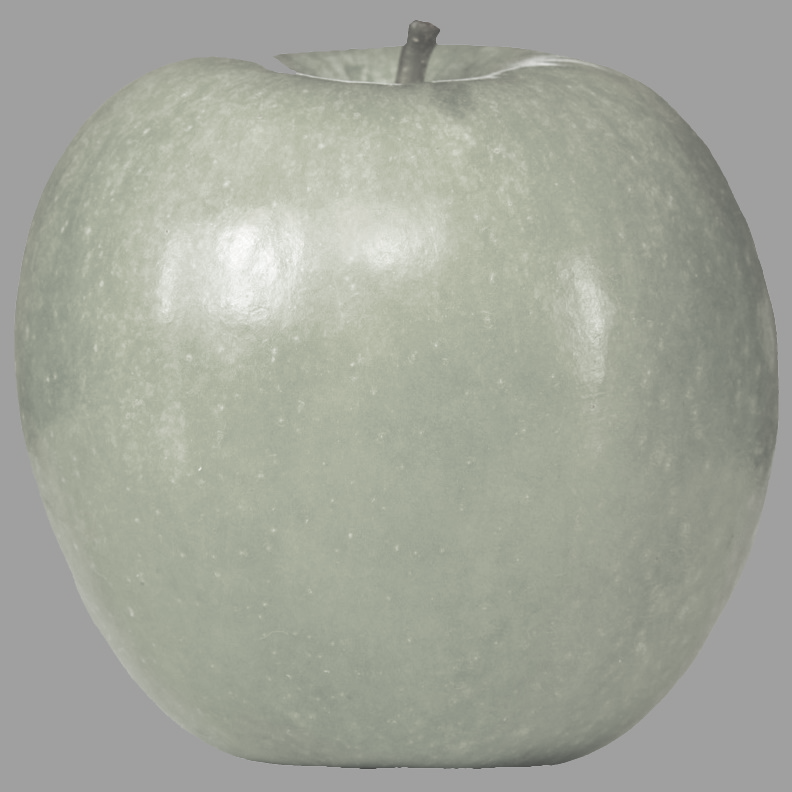

In [167]:
display(images[0])

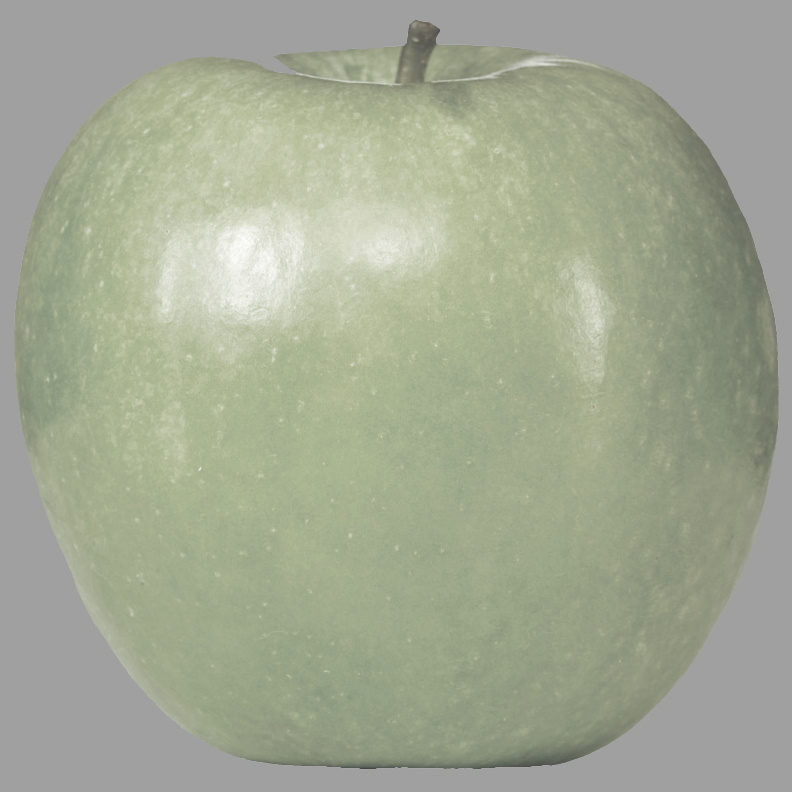

In [196]:
display(images[len(images)//2])

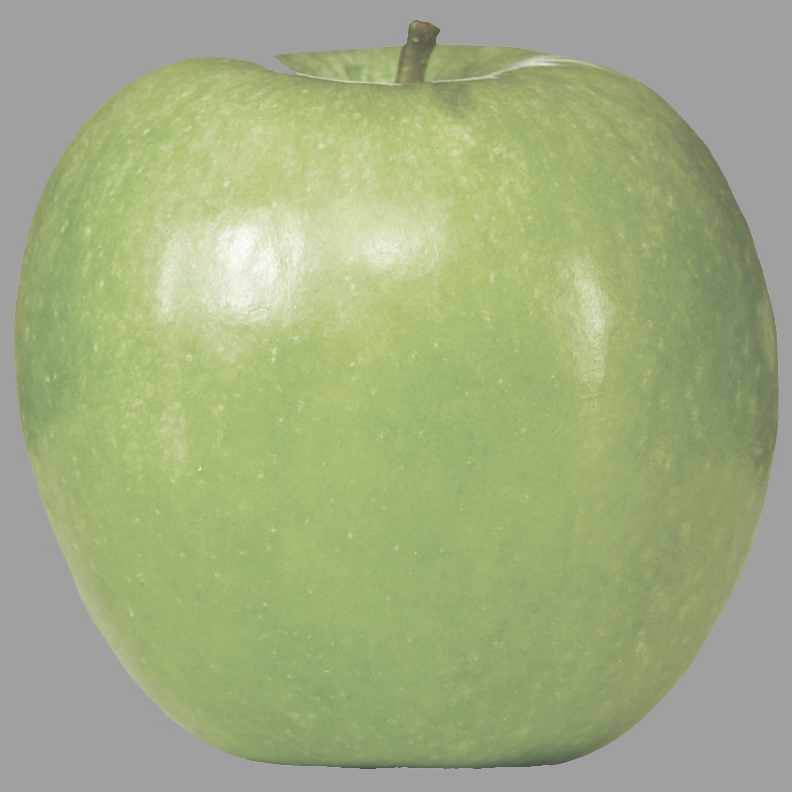

In [168]:
display(images[-1])

In [176]:
alphas

array([0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 , 0.3 ,
       0.4 , 0.5 ])

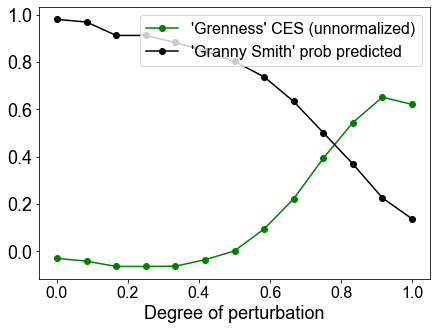

In [195]:
plt.figure(figsize=[7, 5])
plt.plot(np.linspace(0,1,len(alphas)), 3*np.array(ces)[::-1], marker='o', color='green', label='\'Grenness\' CES (unnormalized)')
plt.plot(np.linspace(0,1,len(alphas)), preds[::-1], marker='o', color='black', label='\'Granny Smith\' prob predicted ')
plt.yticks(fontname='Arial', fontsize=18)
plt.xticks(fontname='Arial', fontsize=16)
# plt.ylabelfontname='Arial', fontsize=18)
plt.xlabel('Degree of perturbation', fontname='Arial', fontsize=18)
plt.legend(prop={'family':'Arial', 'size':16}, loc="upper right")

# 50 Images

In [197]:
from google_images_download import google_images_download   #importing the library

response = google_images_download.googleimagesdownload()   #class instantiation

arguments = {"keywords":"granny smith apple","limit":100,"print_urls":True, "size":"medium"}   #creating list of arguments
paths = response.download(arguments)   #passing the arguments to the function
print(paths)


Item no.: 1 --> Item name = granny smith apple
Evaluating...
Starting Download...
Image URL: https://www.stemilt.com/wp-content/uploads/2016/07/Granny-Smith.png
Completed Image ====> 1.granny-smith.png
Image URL: https://chiefrivernursery.com/media/catalog/product/cache/9820170e8aaf17063e79ec8448f2da6f/g/r/granny-smith-apple-fruit_1.jpg
Completed Image ====> 2.granny-smith-apple-fruit_1.jpg
Image URL: https://minnetonkaorchards.com/wp-content/uploads/2020/08/Granny-Smith-Apples-Featured.jpg
Completed Image ====> 3.granny-smith-apples-featured.jpg
Image URL: https://www.markon.com/sites/default/files/styles/large/public/pi_photos/Apples_Granny_Smith_Hero.jpg
Completed Image ====> 4.apples_granny_smith_hero.jpg
Image URL: http://specialtyproduce.com/sppics/14249.png
Completed Image ====> 5.14249.png
Image URL: https://www.freshpoint.com/wp-content/uploads/commodity-granny-smith.jpg
Completed Image ====> 6.commodity-granny-smith.jpg
Image URL: https://www.kroger.com/product/images/large/

Completed Image ====> 43.granny-smith_variety-page.png
Image URL: https://purewows3.imgix.net/images/articles/2021_03/types_of_apples_CAT.jpg?auto=format,compress&cs=strip
Completed Image ====> 44.types_of_apples_cat.jpg
Image URL: https://nutritionix-api.s3.amazonaws.com/5c8f24d404963d5921e506e8.jpeg
Completed Image ====> 45.5c8f24d404963d5921e506e8.jpeg
Image URL: https://www.dalival.com/wp-content/uploads/2016/07/GRANNY-CHALLENGER-PRINCIPALE-LOGO-RECT.png
Completed Image ====> 46.granny-challenger-principale-logo-rect.png
Image URL: https://www.kroger.com/product/images/large/front/0001111091829
Completed Image ====> 47.0001111091829.webp
Image URL: https://www.nicepng.com/png/detail/300-3001456_granny-smith-apples-granny-smith-apple-png.png
Completed Image ====> 48.300-3001456_granny-smith-apples-granny-smith-apple-png.png
Image URL: https://producegeek.com/wp-content/uploads/2017/01/organic-granny-smith-apples-02-940x626.jpg
Completed Image ====> 49.organic-granny-smith-apples-02-

Completed Image ====> 86.38-388925_granny-smith-apple-png-transparent-png.png
Image URL: https://liquorpei.com/wp-content/themes/peiliquor/bottle-shots/19541H.jpg
Completed Image ====> 87.19541h.jpg
Image URL: https://www.researchgate.net/profile/Javier-Sanchez-Contreras/publication/304822601/figure/fig1/AS:380513010372608@1467732779215/Sun-injury-categories-Granny-Smith-apples.png
Completed Image ====> 88.sun-injury-categories-granny-smith-apples.png
Image URL: https://www.amusingfoodie.com/wp-content/uploads/2013/09/cooking-apples-eating-apples-horizontal-1024x683.png
Completed Image ====> 89.cooking-apples-eating-apples-horizontal-1024x683.png
Image URL: https://i.pinimg.com/originals/60/27/2d/60272dc74fc57aaf1583e32485223e0e.jpg
Completed Image ====> 90.60272dc74fc57aaf1583e32485223e0e.jpg


Unfortunately all 100 could not be downloaded because some images were not downloadable. 90 is all we got for this search filter!

Errors: 10

({'granny smith apple': ['C:\\Users\\islam\\dev\\r

In [206]:
len(ces_scores)

20

array([0.08143903, 0.0994096 , 0.11797524, 0.1378712 , 0.16091861,
       0.17871474, 0.18488706, 0.1818579 , 0.16777004, 0.15073263])

In [250]:
ces_scores_norm = [(np.array(c)-np.array(c).min())/(np.array(c).max()-np.array(c).min()) for c in ces_scores[:25]]

Text(0.5, 0, 'Degree of perturbation')

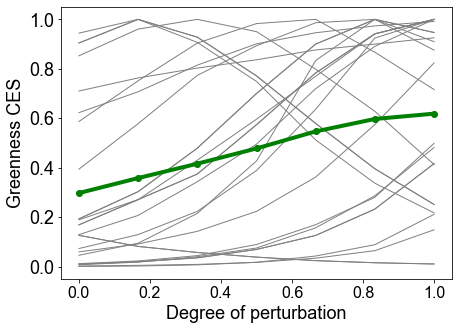

In [263]:
plt.figure(figsize=[7, 5])

plt.plot(np.linspace(0, 1, 7), np.fliplr(np.array(ces_scores_norm)[:,3:-3]).T, color='gray', lw=1)
plt.plot(np.linspace(0, 1, 7), np.mean(np.fliplr(np.array(ces_scores_norm)[:,3:-3]).T, axis=1), color='green', lw=4, marker='o')

plt.yticks(fontname='Arial', fontsize=18)
plt.xticks(fontname='Arial', fontsize=16)
plt.ylabel('Greenness CES', fontname='Arial', fontsize=18)
plt.xlabel('Degree of perturbation', fontname='Arial', fontsize=18)

In [245]:
np.save('ces_scores_20', ces_scores)

In [246]:
path = 'downloads\\granny smith apple'
# ces_scores = []

for i in tqdm.tqdm(os.listdir(path)[:20]):
    image_path = os.path.join(path, i)    
    
    img = PIL.Image.open(image_path).convert("RGB")
    img_ = PIL.Image.open(image_path).convert("L").convert("RGB")    
    
    alphas = np.concatenate([np.linspace(0.12, 0.3, 10), np.linspace(0.3, 0.5, 3)])
    ces = []
    
    for alpha in alphas:
        average_img = PIL.Image.fromarray(np.array(alpha*np.array(img) + (1-alpha)*np.array(img_), dtype=np.uint8))
        tensor = data_transforms(average_img).unsqueeze(0)
        pred, concept_scores, concept_scores_list = get_concept_scores(tensor, "Granny Smith")
        ces.append(concept_scores['greenness'])
        
    ces_scores.append(ces)

  0%|          | 0/20 [00:00<?, ?it/s]c:\users\islam\appdata\local\programs\python\python39\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 50%|█████     | 10/20 [03:29<03:29, 20.96s/it]


KeyboardInterrupt: 